<div class="usecase-title">Analysis of Factors Effecting Bin Fill Levels at Argyle Square</div>

<div class="usecase-authors"><b>Authored by: </b>Alison Collins</div>
<div class="usecase-duration"><b>Duration: </b>90 mins</div>
<div class="usecase-level"><b>Level: </b>Intermediate</div>
<div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>

<div class="usecase-section-header">Scenario</div>

 
1. I am planning an event at Argyle Square and need to know if there will be sufficient waste collection space in the bins, so need to know what conditions cause bin fill level to be higher.

2. I am a waste collection planner and need to know what conditions may cause bins to be at a fuller level.

<div class="usecase-section-header">What this use case will teach you</div>


At the end of this use case you will:
- Import data using API v2.1 GET request with /exports extension
- Filtering of dataframes
- Use of date time to resample data by different time increments
- Merging and concatenating of dataframes
- Create box plots from a dataframe to view datasets
- Create scatterplots from a dataframe to identify variable relationships
- Create pairplots from a dataframe to identify variable relationships
- Use Pearson correlation heatmap to identify linear variable relationships
- Use distance calculation to identify non-linear variable relationships
- Feature engineering background


<div class="usecase-section-header">Why do we need to understand which variables impact bin fill levels?</div>

Prediction of bin fill levels can assist in solving two problems, that of issues relating to overflowing bins and that of rising costs to council for waste collection. If bin fill can be predicted, bins can be emptied in a timely manner,  ensuring there is space for new waste generated and reducing waste collection costs.</br>

Overflowing waste is a growing problem in modern cities. When bins overflow, it causes a liturgy of problems. These include streets cluttered with rubbish that cannot be placed in bins; rubbish washing into storm water drainage causing water pollution and an increase in bacteria, insects and vermin which cause health risks to humans <a href="#fn-1">[1]</a>. These factors also contrinute to a reduction in the wellbeing of inhabitants.</br>

In waste collection services, the main cost is in the distrance travelled by a truck to collect rubbish <a href="#fn-2">[2]</a>. In the situation where a container is known to be not full and predicted to have little rubbish added, the bin need not be collected. This means that the bin can be taken off the truck's route, reducing the distance travelled by the truck and thus saving costs in fuel, time and long term truck maintinence.
 



<div class="usecase-section-header">Which variables will be investigated?</div>

The variables of interest in this investigation are those of bin fill level, weather and human activity. Human activity includes numbers of people at Argyle square, how long people stay at Argyle square and use of stage at Argyle square. Numbers of people and the length they are at the location for are found in the Blix Visits dataset. Weather includes temperature and humidity, data of which can be found in the Sound Stage Activity dataset, along with measures of stage use. Bin fill level is found in the bin sensor dataset.

### RELEVANT DATASETS

[Blix Visits](https://data.melbourne.vic.gov.au/explore/dataset/blix-visits/information/)

- The Blix Visits data uses mobile phone counting <a href="#fn-3">[3]</a> to count the number of phones in a location. This dataset reports data at 3 minute intervals for each sensor; including a total count, dwell time and average dwell time (in minutes) of individual mobile phones. The blix sensors at Argle Square are the only ones of interest, so the data will be filtered at venueId 7780, Argyle Square. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

[Argyle Square Sound Stage Activity](https://data.melbourne.vic.gov.au/explore/dataset/meshed-sensor-type-3/information/)
- The sound stage at Argyle Park has been fitted with three Elsys sensors <a href="#fn-3">[3]</a> to monotor movement on the stage. This data is reported every 3 minutes and includes an interger measurement value of motion and visit. In addition, the sensors also measure and report environmental data of temperature, humidity and light. This dataset is imported from Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

[Netvox R718X Bin Sensor](https://data.melbourne.vic.gov.au/explore/dataset/netvox-r718x-bin-sensor/information/?disjunctive.dev_id)
- Netvox R718X measures distance using an ultrasonic ranging <a href="#fn-3">[3]</a>, which is used to calculate the bin fill level reported in the bin sensor data set. These levels are recorded every 15 minutes. This dataset aso reports the senros name, location and timedate data for the reading. Temperature and battery level are also recorded but not used in this use case. There are many bins across Argyle Square using this technology, but only bins from the area adjactent to the sound stage have been included in this investigation. This dataset is imported from the Melbourne Open Data website, using a GET request with /export/ extension, from API V2.1.

### REQUIRED MODULES

In [2]:
# Dependencies
import warnings
warnings.filterwarnings("ignore")

# Import required modules
import requests
import numpy as np
import pandas as pd
import io
import folium
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import dcor
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import statistics

### IMPORT DATASETS

Import datasets using API v2.1 GET request with /exports/

In [144]:
from io import StringIO

# Function to collect datasets using API
def datasetcollect(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = " "
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,  # all records
        'lang': 'en',
        'timezone': 'UTC',
        #'api_key': apikey
    }

    # GET request
    response = requests.get(url, params=params)

    if response.status_code == 200:
        # StringIO to read the CSV data
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [145]:
# Import stage activity dataset
dataset_id = 'meshed-sensor-type-3'
stage_activity_all = datasetcollect(dataset_id)
print(len(stage_activity_all))
stage_activity_all.head(3)

382460


,dev_id,sensor_name,time,temperature,humidity,light,motion,visit,vdd,lat_long
0,ers-55eb,NaN,2022-12-13T20:09:42+00:00,10.5,89,297,0,0,3638,NaN
1,ers-55ea,NaN,2022-12-13T20:26:03+00:00,10.6,88,136,0,0,3635,NaN
2,ers-55eb,NaN,2022-12-13T20:34:47+00:00,10.8,89,698,0,0,3638,NaN


In [146]:
# Import bin sensor dataset
dataset_id = 'netvox-r718x-bin-sensor'
bin_sensor_all = datasetcollect(dataset_id)
print(len(bin_sensor_all))
bin_sensor_all.head(3)

289900


,dev_id,time,temperature,distance,filllevel,battery,lat_long,sensor_name,fill_level
0,r718x-6778,2023-02-26T08:16:47+00:00,19.0,209.0,73.0,3.6,"-37.8025943, 144.9658434",r718x-bin sensor 8,71.0
1,r718x-6f16,2023-02-26T08:18:10+00:00,19.9,202.0,74.0,3.6,"-37.8028794, 144.9662728",r718x-bin sensor 17,72.0
2,r718x-677d,2023-02-26T08:18:02+00:00,20.7,200.0,74.0,3.6,"-37.8021051, 144.9654523",r718x-bin sensor 11,72.0


In [147]:
# Import blix mobile phone counter dataset
dataset_id = 'blix-visits'
blix_phones_all = datasetcollect(dataset_id)
print(len(blix_phones_all))
blix_phones_all.head(3)

71900


,datetime,keys1,total,dwell,sensor_name,sensor_type,lat_long,avg_dwell
0,2022-08-25T22:00:00+00:00,8171,27,5697,Pedestrian Sensor-Birrarung Marr,Mobile phone counting,"-37.8209898, 144.9759397",3.0
1,2022-08-26T08:00:00+00:00,8171,115,42090,Pedestrian Sensor-Birrarung Marr,Mobile phone counting,"-37.8209898, 144.9759397",6.0
2,2022-08-26T02:00:00+00:00,7780,228,94848,Pedestrian Sensor-Argyle Sq,Mobile phone counting,"-37.8025805, 144.9656012",6.0


### DATA PREPROCESSING

First step is to correlate date range of datasets, so they are all within the same range of dates.

In [148]:
# check data types in columns
print("Data types in Stage activity")
print(stage_activity_all.dtypes)

print("Data types in Bin Sensor")
print(bin_sensor_all.dtypes)

print("Data types in Blix Phones")
print(blix_phones_all.dtypes)

Data types in Stage activity
dev_id          object
sensor_name    float64
time            object
temperature    float64
humidity         int64
light            int64
motion           int64
visit            int64
vdd              int64
lat_long       float64
dtype: object
Data types in Bin Sensor
dev_id          object
time            object
temperature    float64
distance       float64
filllevel      float64
battery        float64
lat_long        object
sensor_name     object
fill_level     float64
dtype: object
Data types in Blix Phones
datetime        object
keys1            int64
total            int64
dwell            int64
sensor_name     object
sensor_type     object
lat_long        object
avg_dwell      float64
dtype: object


In [149]:
# convert date time columns to date time type
stage_activity_all['date_time'] = pd.to_datetime(stage_activity_all['time'])
stage_activity_all = stage_activity_all.drop(['time'], axis=1)

bin_sensor_all['date_time'] = pd.to_datetime(bin_sensor_all['time'])
bin_sensor_all = bin_sensor_all.drop(['time'], axis=1)

blix_phones_all['date_time'] = pd.to_datetime(blix_phones_all['datetime'])
blix_phones_all = blix_phones_all.drop(['datetime'], axis=1)

In [150]:
# Check oldest and most recent dates in datasets

print("Date range in stage activity")
print(stage_activity_all["date_time"].min())
print(stage_activity_all["date_time"].max())

print("Date range in bin sensor")
print(bin_sensor_all["date_time"].min())
print(bin_sensor_all["date_time"].max())

print("Date range in blix phones")
print(blix_phones_all["date_time"].min())
print(blix_phones_all["date_time"].max())

Date range in stage activity
2022-11-29 06:05:16+00:00
2024-05-09 12:56:13+00:00
Date range in bin sensor
2023-02-26 08:16:37+00:00
2023-12-21 04:37:29+00:00
Date range in blix phones
2021-12-31 13:00:00+00:00
2023-12-20 12:00:00+00:00


In [151]:
# Drop rows so that all datasets have the same date range

stage_activity= stage_activity_all[(stage_activity_all['date_time'] > '2023-2-26') & (stage_activity_all['date_time'] <= '2024-3-26')]

bin_sensor= bin_sensor_all[(bin_sensor_all['date_time'] > '2023-2-26') & (bin_sensor_all['date_time'] <= '2024-3-26')]

blix_phones= blix_phones_all[(blix_phones_all['date_time'] > '2023-2-26') & (blix_phones_all['date_time'] <= '2024-3-26')]


Second step is to check locations of sensors and check if they are within the same area. This will be dont by mapping Blix count and bin sensors on a map. Stage activty sensors do not need to be mapped as they are only at the Argyle Square stage area.

In [152]:
# Select unique locations
blix_location = blix_phones.drop_duplicates(subset=['keys1'])
bin_location = bin_sensor.drop_duplicates(subset=['sensor_name'])

# Drop na values
bin_location = bin_location.dropna(axis=0, how='any')
blix_location = blix_location.dropna(axis=0, how='any')


In [153]:

# Create separate columns for latitude and longitude
blix_location[['latitude','longitude']] = blix_location['lat_long'].str.split(', ',expand=True)
bin_location[['latitude','longitude']] = bin_location['lat_long'].str.split(', ',expand=True)

# Convert to geo-dataframe
bin_loc = gpd.GeoDataFrame(bin_location, geometry=gpd.points_from_xy(bin_location['latitude'], bin_location['longitude']))
blix_loc = gpd.GeoDataFrame(blix_location, geometry=gpd.points_from_xy(blix_location['latitude'], blix_location['longitude']))

In [154]:
# check locations of datasets
# Initialize the map at Melbourne and store it in a m object
m = folium.Map(location = [-37.802533, 144.96567],zoom_start = 18)

# Add ped_count centroids locations
for i in range(0,len(bin_loc)):
   folium.Marker(
      location=[bin_loc.iloc[i]['latitude'], bin_loc.iloc[i]['longitude']],
      popup='Name = {}'.format(bin_loc['sensor_name'].values[i]),
      icon=folium.Icon(color="blue",prefix='fa', icon='trash-can')
   ).add_to(m)

# Add insect locations
for i in range(0,len(blix_loc)):
   folium.Marker(
      location=[blix_loc.iloc[i]['latitude'], blix_loc.iloc[i]['longitude']],
      popup='Name = {}'.format(blix_loc['keys1'].values[i]),
      icon=folium.Icon(color="pink",prefix='fa', icon='male'),
   ).add_to(m)
   
# A title can be added to the map, if desired.
m.get_root().html.add_child(folium.Element("<h3 align='center'>Sensor Locations Argyle Square</h3>"))

# Show the map
m

Clicking on the icons shows the names of the sensors. These names can be used to drop un-ncessessary data in preprocessing of each dataset.

##### Bin Dataset Preprocessing

Preprocessing will keep only the bin adjacent to the blix counting sensor. Unnescessary columns will be dropped. Fill level will be checked to determine if it is within appropraite ranges (not above or below 0 - 100% full), and rows with values outside this will be deleted. Rows with null values are deleted. Additionally, the bin data is sampled every quarter hour. This will need to be resampled to hourly to match the blix counting data.

In [203]:
# BIN DATASET PREPROCESSING

# Keep only rows with bin sensors in the sensor area
filtered_bin_sensor = bin_sensor[bin_sensor["sensor_name"].isin(["r718x-bin sensor 12","r718x-bin sensor 8","r718x-bin sensor 18","r718x-bin sensor 19"])]
filtered_bin_sensor.head(3)

# Drop columns from bin dataframe
filtered_bin_sensor = filtered_bin_sensor[['fill_level','date_time',"sensor_name"]]

# Drop rows with na values
filtered_bin_sensor = filtered_bin_sensor.dropna(axis=0, how='any')

# Check max and min values in bin fill levels
# Max and min of filllevel column
print(filtered_bin_sensor['fill_level'].agg(['min', 'max']))

# Drop rows where bin fill column is less than 0
filtered_bin_sensor = filtered_bin_sensor.drop(filtered_bin_sensor[filtered_bin_sensor['fill_level'] <0].index)

# Max and min of filllevel column confirm
print(filtered_bin_sensor['fill_level'].agg(['min', 'max']))


# Create an empty dataframe
hourly_bin_sensor = pd.DataFrame(columns=['fill_level','sensor_name'])

# Resample the data by hour
sensor_name_list = filtered_bin_sensor["sensor_name"].unique()
# Loop through senor names, selecting sections of dataframe to resample
for sensor in sensor_name_list:
        filter_me = filtered_bin_sensor[filtered_bin_sensor["sensor_name"].isin([sensor])]
        df_resampled = filter_me.set_index('date_time').resample('D').agg({'fill_level': 'mean'})
        df_resampled['sensor_name'] = sensor
        hourly_bin_sensor = pd.concat([hourly_bin_sensor, df_resampled])

# Reset index
hourly_bin_sensor = hourly_bin_sensor.reset_index()

# Change column name to date_time
hourly_bin_sensor = hourly_bin_sensor.rename(columns={'index': 'date_time'})

# Check the length of the dataframe
print(len(hourly_bin_sensor))
hourly_bin_sensor.head(2)


min   -8877.0
max      72.0
Name: fill_level, dtype: float64
min     0.0
max    72.0
Name: fill_level, dtype: float64
1123


,date_time,fill_level,sensor_name
0,2023-02-26 00:00:00+00:00,67.298246,r718x-bin sensor 8
1,2023-02-27 00:00:00+00:00,51.338462,r718x-bin sensor 8


##### Stage Dataset Preprocessing

Preprocessing will drop un-nesscessary columns. Rows with null values are deleted. The stage data is sampled every quarter hour. This will need to be resampled to hourly to match the blix counting data.

In [204]:
# STAGE DATASET PREPROCESSING

# Set index to datetime column
stage_activity.set_index('date_time', inplace=True)

# Resample the data by hour
grouped_stage_activity = stage_activity.resample('H').agg({'motion':'max','temperature':'mean','humidity':'mean','light':'mean'})

# Drop rows with na values
grouped_stage_activity = grouped_stage_activity.dropna(axis=0, how='any')

# Add index back in
grouped_stage_activity = grouped_stage_activity.reset_index()

# Show dataframe
grouped_stage_activity.head(3)


KeyError: "None of ['date_time'] are in the columns"

##### Blix Mobiles Dataset Preprocessing

Preprocessing will select only blix count data atArgyle square sonsor. Un-nesscessary columns will be dropped. Rows with null values are deleted.

In [205]:
# Keep only rows with sensores in the stage area
filtered_blix_phone = blix_phones[blix_phones["keys1"].isin([7780])]

# Drop columns from stage_activity dataframe
filtered_blix_phone = filtered_blix_phone[['date_time','total','avg_dwell']]

# Drop rows with na values
filtered_blix_phone = filtered_blix_phone.dropna(axis=0, how='any')

filtered_blix_phone.head(3)

,date_time,total,avg_dwell
32826,2023-02-26 07:00:00+00:00,223,3.0
32828,2023-02-26 06:00:00+00:00,237,6.0
32833,2023-02-26 05:00:00+00:00,186,6.0


##### Merge hourly dataframes

As all dataframes are now sampled hourly, dataframes can be merged with all data in the one dataframe.

In [206]:
# Merge grouped bin sensor and stage activity
merged_dataframe_A = pd.merge(hourly_bin_sensor, grouped_stage_activity, on="date_time",how='outer')

# Merge new dataframe and blix count data
hourly_merged_dataframe = pd.merge(merged_dataframe_A, filtered_blix_phone, on="date_time",how='outer')

# Drop any remaining null values
hourly_merged_dataframe = hourly_merged_dataframe.dropna(axis=0, how='any')

hourly_merged_dataframe.head(9)


,date_time,fill_level,sensor_name,motion,temperature,humidity,light,total,avg_dwell
4,2023-02-27 00:00:00+00:00,51.338462,r718x-bin sensor 8,1.0,21.267857,68.142857,2179.321429,160.0,4.0
5,2023-02-27 00:00:00+00:00,72.000000,r718x-bin sensor 12,1.0,21.267857,68.142857,2179.321429,160.0,4.0
6,2023-02-27 00:00:00+00:00,71.842105,r718x-bin sensor 18,1.0,21.267857,68.142857,2179.321429,160.0,4.0
7,2023-02-27 00:00:00+00:00,36.115385,r718x-bin sensor 19,1.0,21.267857,68.142857,2179.321429,160.0,4.0
8,2023-02-28 00:00:00+00:00,50.394737,r718x-bin sensor 8,1.0,17.129032,86.000000,373.000000,100.0,4.0
9,2023-02-28 00:00:00+00:00,72.000000,r718x-bin sensor 12,1.0,17.129032,86.000000,373.000000,100.0,4.0
10,2023-02-28 00:00:00+00:00,71.835443,r718x-bin sensor 18,1.0,17.129032,86.000000,373.000000,100.0,4.0
11,2023-02-28 00:00:00+00:00,42.426829,r718x-bin sensor 19,1.0,17.129032,86.000000,373.000000,100.0,4.0
12,2023-03-01 00:00:00+00:00,68.975000,r718x-bin sensor 8,2.0,21.739286,60.142857,2229.321429,141.0,4.0


### EXPLORATORY DATA ANALYSIS

#### Hourly Data

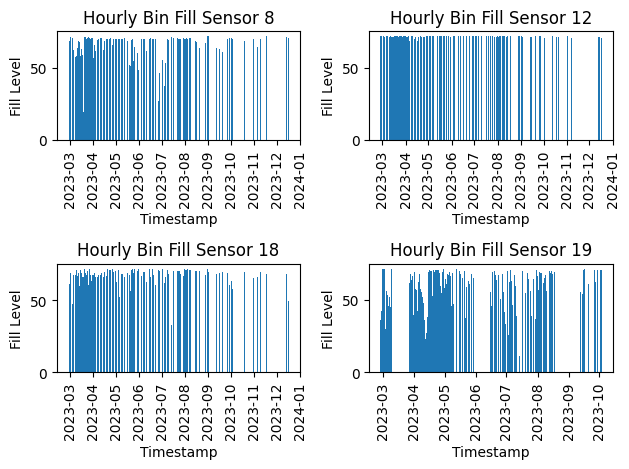

In [237]:
# Select for indiviual sensors
sensor8 = hourly_merged_dataframe[hourly_merged_dataframe["sensor_name"].isin(["r718x-bin sensor 8"])]
sensor12 = hourly_merged_dataframe[hourly_merged_dataframe["sensor_name"].isin(["r718x-bin sensor 12"])]
sensor18 = hourly_merged_dataframe[hourly_merged_dataframe["sensor_name"].isin(["r718x-bin sensor 18"])]
sensor19 = hourly_merged_dataframe[hourly_merged_dataframe["sensor_name"].isin(["r718x-bin sensor 19"])]

plt.subplot(2, 2, 1)
plt.bar(sensor8['date_time'], sensor8["fill_level"])
plt.title('Hourly Bin Fill Sensor 8')
plt.xlabel('Timestamp')
plt.ylabel('Fill Level')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
plt.bar(sensor12['date_time'], sensor12["fill_level"])
plt.title('Hourly Bin Fill Sensor 12')
plt.xlabel('Timestamp')
plt.ylabel('Fill Level')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
plt.bar(sensor18['date_time'], sensor18["fill_level"])
plt.title('Hourly Bin Fill Sensor 18')
plt.xlabel('Timestamp')
plt.ylabel('Fill Level')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
plt.bar(sensor19['date_time'], sensor19["fill_level"])
plt.title('Hourly Bin Fill Sensor 19')
plt.xlabel('Timestamp')
plt.ylabel('Fill Level')
plt.xticks(rotation=90)

# space between the plots
plt.tight_layout()
plt.show()



In [251]:

null_counts = hourly_merged_dataframe.isnull().sum()

print(null_counts)

fill_level     0
sensor_name    0
motion         0
temperature    0
humidity       0
light          0
total          0
avg_dwell      0
dtype: int64


In [269]:
# Resample the combined bin data by hour
grouped_bin_sensor_hourly = hourly_merged_dataframe.reset_index()
grouped_bin_sensor_hourly = grouped_bin_sensor_hourly.groupby('date_time')[['fill_level','total','motion','temperature','humidity','avg_dwell','light']].mean().reset_index()
grouped_bin_sensor_hourly.head(2)

,date_time,fill_level,total,motion,temperature,humidity,avg_dwell,light
0,2023-02-27 00:00:00+00:00,57.823988,160.0,1.0,21.267857,68.142857,4.0,2179.321429
1,2023-02-28 00:00:00+00:00,59.164252,100.0,1.0,17.129032,86.000000,4.0,373.000000


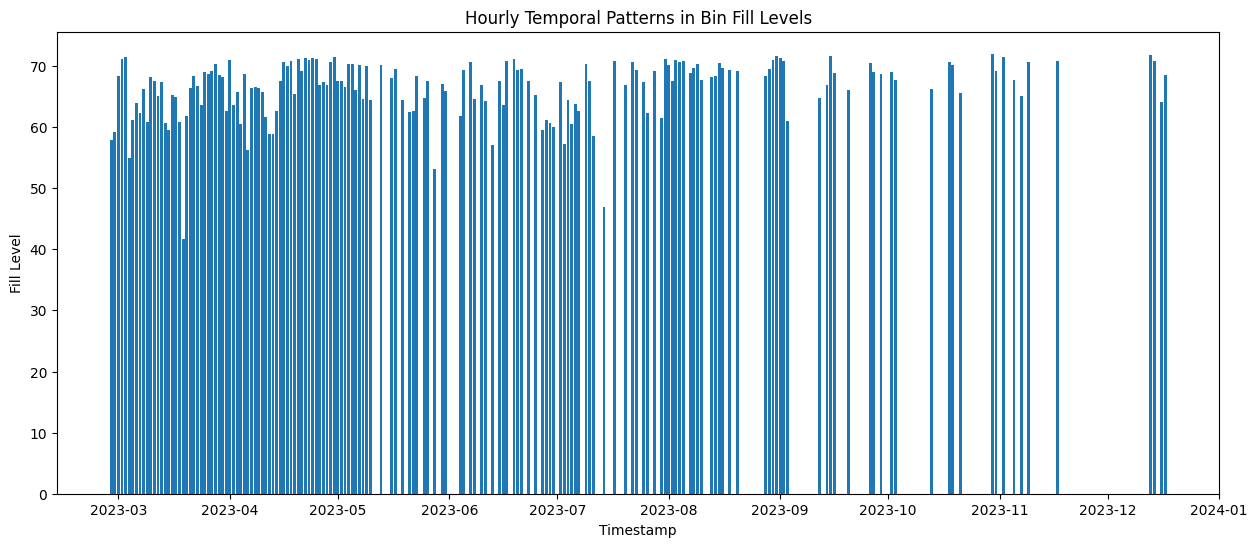

In [270]:
# Plot temporal patterns in average hourly bin fill level
plt.rcParams['figure.figsize'] = [15, 6]
plt.bar(grouped_bin_sensor_hourly['date_time'], grouped_bin_sensor_hourly['fill_level'])
plt.title('Hourly Temporal Patterns in Bin Fill Levels')
plt.xlabel('Timestamp')
plt.ylabel('Fill Level')
plt.show()

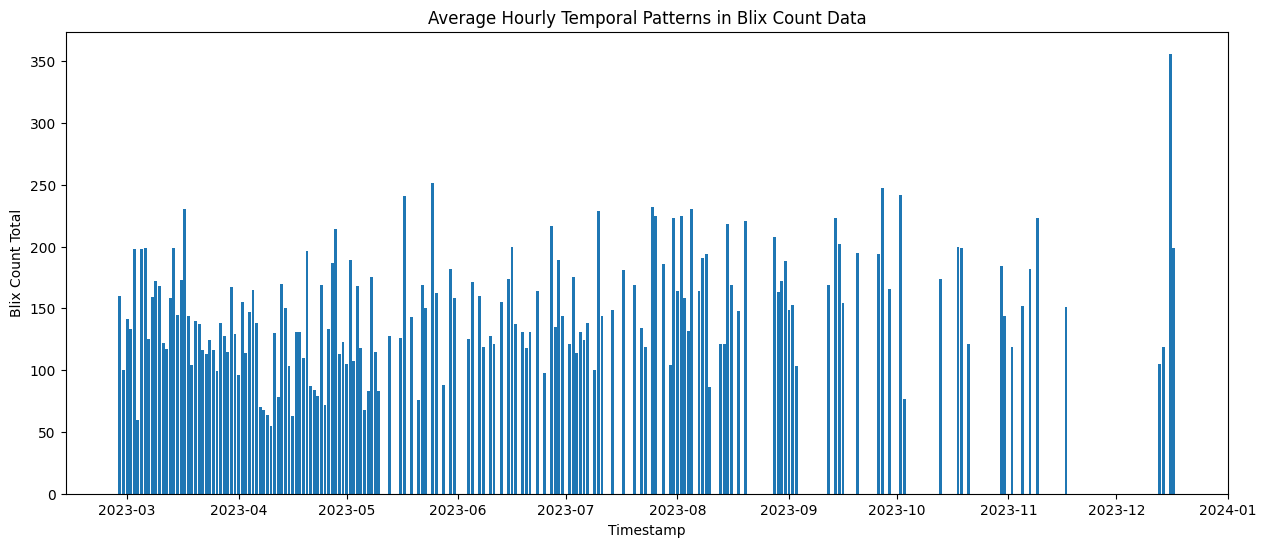

In [271]:
# Plot temporal patterns in average hourly blix count data
plt.bar(grouped_bin_sensor_hourly['date_time'], grouped_bin_sensor_hourly['total'])
plt.title('Average Hourly Temporal Patterns in Blix Count Data')
plt.xlabel('Timestamp')
plt.ylabel('Blix Count Total')
plt.show()

The graphs above both hold averge daily bin fill level and average daily blix counts. Bin fill data shows lots of variation in fill level over time. This is to be expected as bins are filled and emtied during the week. It is seen there are some times were bins have very little rubbish for several days. The Blix count is a measure of how many mobile phones are in the area. There is large variation ove time in these totals as well, with some days seeing large averages and other small averages.

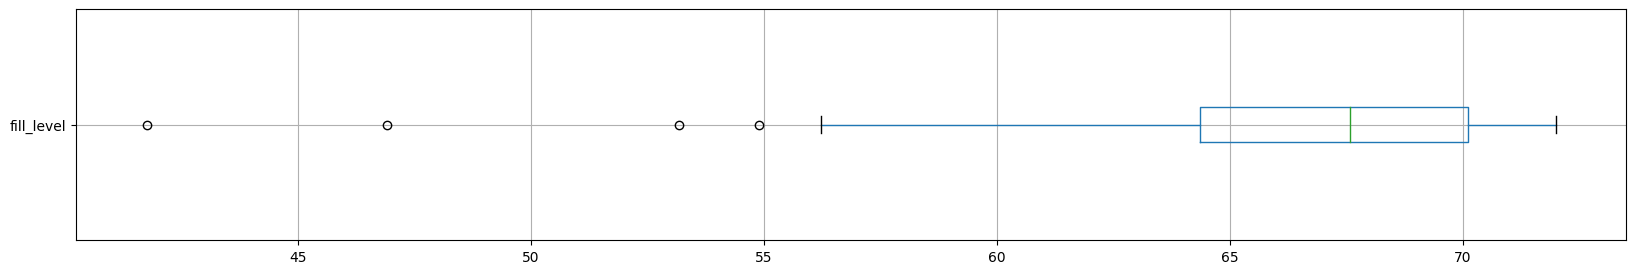

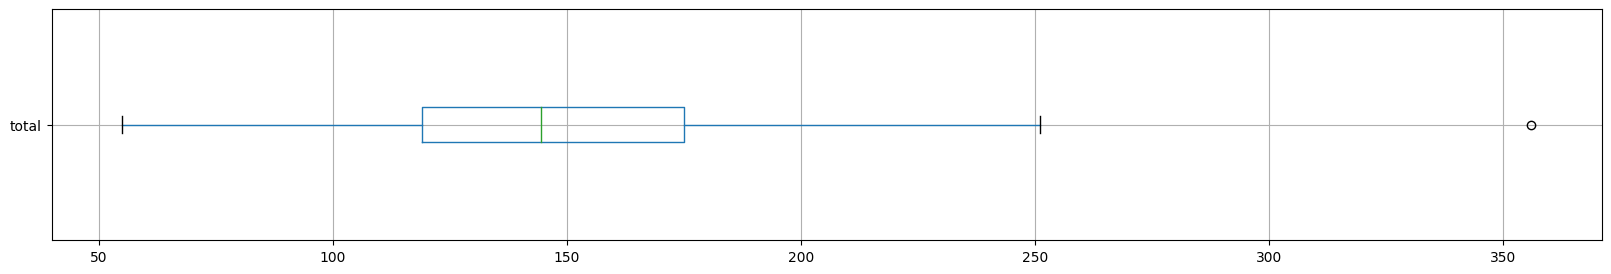

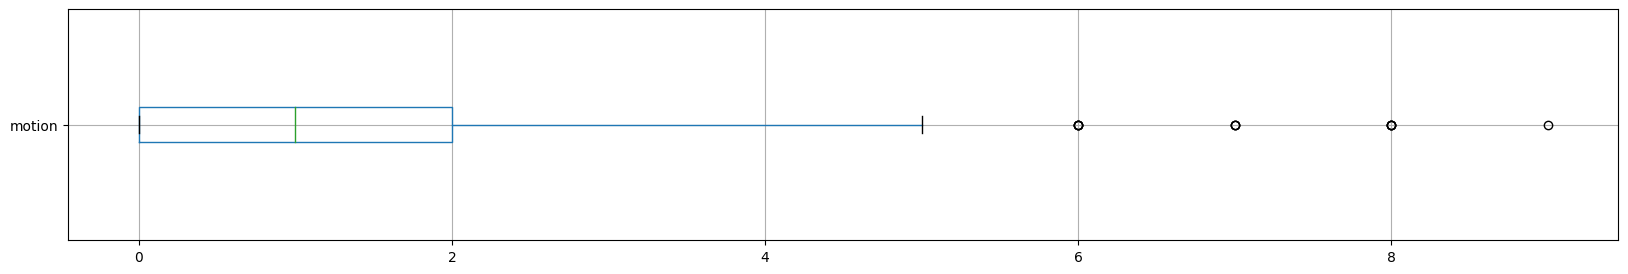

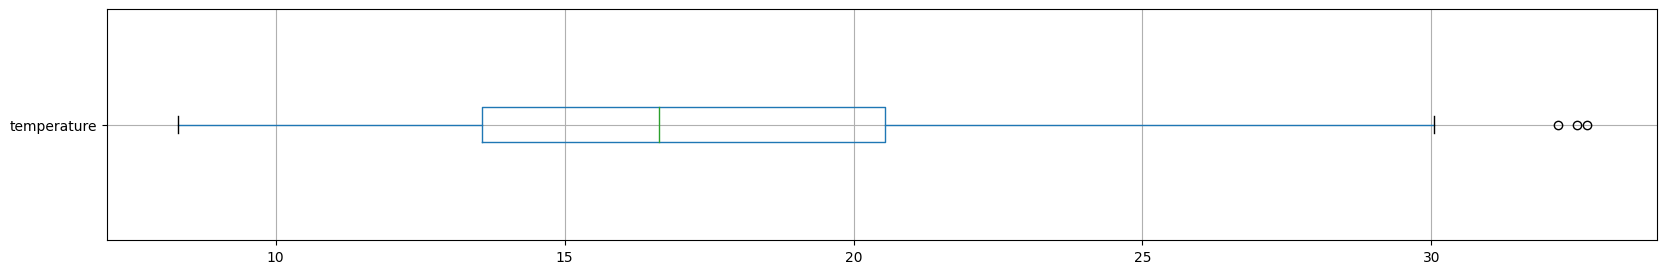

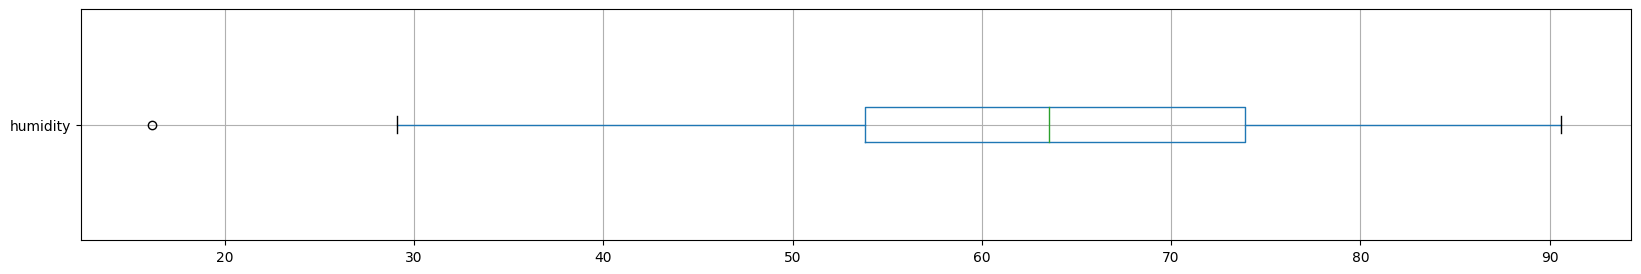

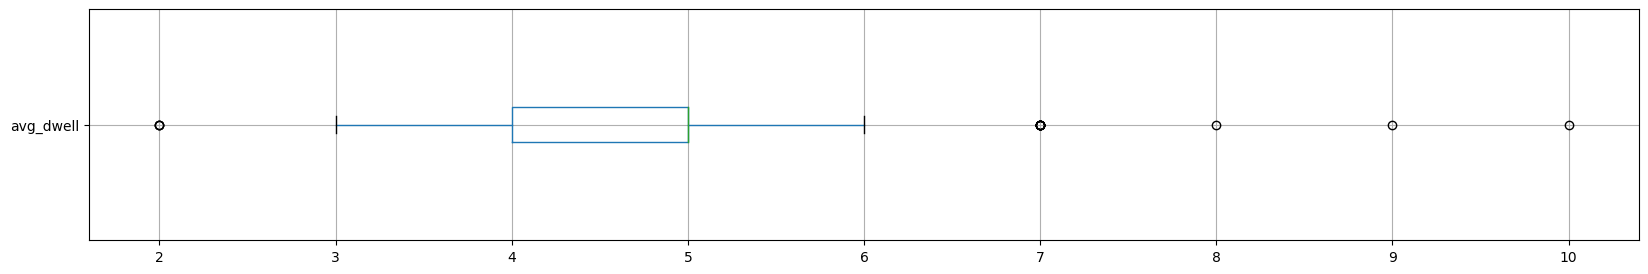

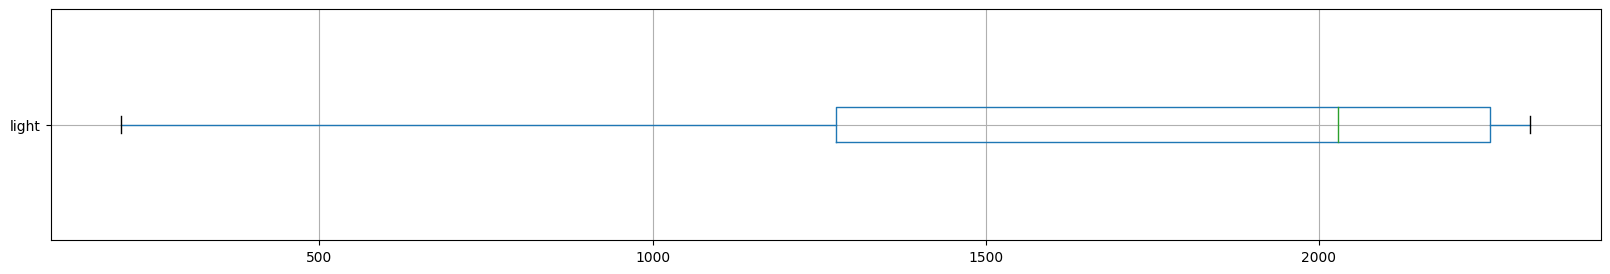

In [273]:
# Use box plots to check for any unexpected values in data
# Set index to datetime column
hourly_merged_date_index = grouped_bin_sensor_hourly.set_index('date_time')
# Iterate over columns and create a horizontal box plot for each one
for column in hourly_merged_date_index:
    plt.rcParams["figure.figsize"] = (20,3)
    plt.figure()
    hourly_merged_date_index.boxplot([column], vert=False)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

The distribtuion for each variable is shown in th ebox plots above. All can be seen to have outliers, but with the exception of total given the type of data, the outliers are within normal range. For toal, there is one data point well beyond any other which will be deleted from the dataset.

In [274]:
# Drop rows total over 500
hourly_merged_date_index = hourly_merged_date_index[hourly_merged_date_index['total'] < 500] 

#### Daily Data

In [276]:
# Create an empty dataframe
daily_merged_dataframe = pd.DataFrame(columns=['fill_level','sensor_name','total','motion','temperature','humidity','light','avg_dwell'])
# Make a list of teh unique values in the sensor column
sensor_name_list = hourly_merged_dataframe["sensor_name"].unique()

# Resample the data by hour
for sensor in sensor_name_list:
    filter_me = hourly_merged_dataframe[hourly_merged_dataframe["sensor_name"].isin([sensor])]
    df_resampled = filter_me.resample('D').agg({
    'fill_level': 'mean',
    'total': 'mean',
    'avg_dwell': 'mean',
    'temperature': 'mean',
    'motion': 'mean',
    'humidity': 'mean',
    'light': 'mean'
    })
    df_resampled['sensor_name'] = sensor
    daily_merged_dataframe = pd.concat([daily_merged_dataframe, df_resampled])

# Reset index
daily_merged_dataframe = daily_merged_dataframe.reset_index()

# Chaneg column name to date_time
daily_merged_dataframe = daily_merged_dataframe.rename(columns={'index': 'date_time'})

daily_merged_dataframe.head(2)

,date_time,fill_level,sensor_name,total,motion,temperature,humidity,light,avg_dwell
0,2023-02-27 00:00:00+00:00,51.338462,r718x-bin sensor 8,160.0,1.0,21.267857,68.142857,2179.321429,4.0
1,2023-02-28 00:00:00+00:00,50.394737,r718x-bin sensor 8,100.0,1.0,17.129032,86.000000,373.000000,4.0


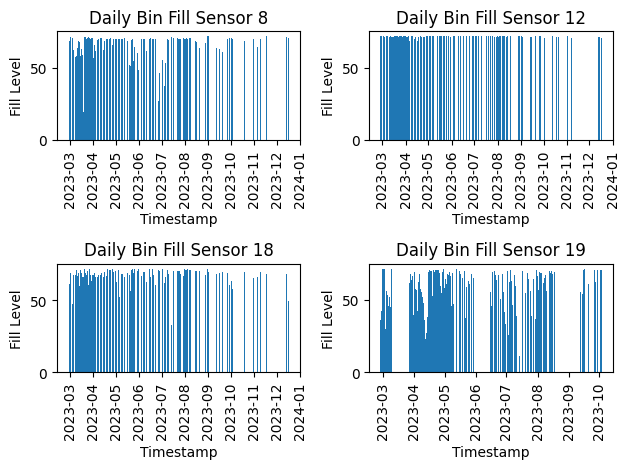

In [277]:
# Select for indiviual sensors
sensor8 = daily_merged_dataframe[daily_merged_dataframe["sensor_name"].isin(["r718x-bin sensor 8"])]
sensor12 = daily_merged_dataframe[daily_merged_dataframe["sensor_name"].isin(["r718x-bin sensor 12"])]
sensor18 = daily_merged_dataframe[daily_merged_dataframe["sensor_name"].isin(["r718x-bin sensor 18"])]
sensor19 = daily_merged_dataframe[daily_merged_dataframe["sensor_name"].isin(["r718x-bin sensor 19"])]

plt.subplot(2, 2, 1)
plt.bar(sensor8['date_time'], sensor8["fill_level"])
plt.title('Daily Bin Fill Sensor 8')
plt.xlabel('Timestamp')
plt.ylabel('Fill Level')
plt.xticks(rotation=90)

plt.subplot(2, 2, 2)
plt.bar(sensor12['date_time'], sensor12["fill_level"])
plt.title('Daily Bin Fill Sensor 12')
plt.xlabel('Timestamp')
plt.ylabel('Fill Level')
plt.xticks(rotation=90)

plt.subplot(2, 2, 3)
plt.bar(sensor18['date_time'], sensor18["fill_level"])
plt.title('Daily Bin Fill Sensor 18')
plt.xlabel('Timestamp')
plt.ylabel('Fill Level')
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
plt.bar(sensor19['date_time'], sensor19["fill_level"])
plt.title('Daily Bin Fill Sensor 19')
plt.xlabel('Timestamp')
plt.ylabel('Fill Level')
plt.xticks(rotation=90)

# space between the plots
plt.tight_layout()
plt.show()

In [278]:
# Resample the combined bin data by day
grouped_bin_sensor_daily = daily_merged_dataframe.reset_index()
grouped_bin_sensor_daily = grouped_bin_sensor_daily.groupby('date_time')[['fill_level','total','motion','temperature','humidity','avg_dwell','light']].mean().reset_index()
grouped_bin_sensor_daily.head(2)

,date_time,fill_level,total,motion,temperature,humidity,avg_dwell,light
0,2023-02-27 00:00:00+00:00,57.823988,160.0,1.0,21.267857,68.142857,4.0,2179.321429
1,2023-02-28 00:00:00+00:00,59.164252,100.0,1.0,17.129032,86.000000,4.0,373.000000


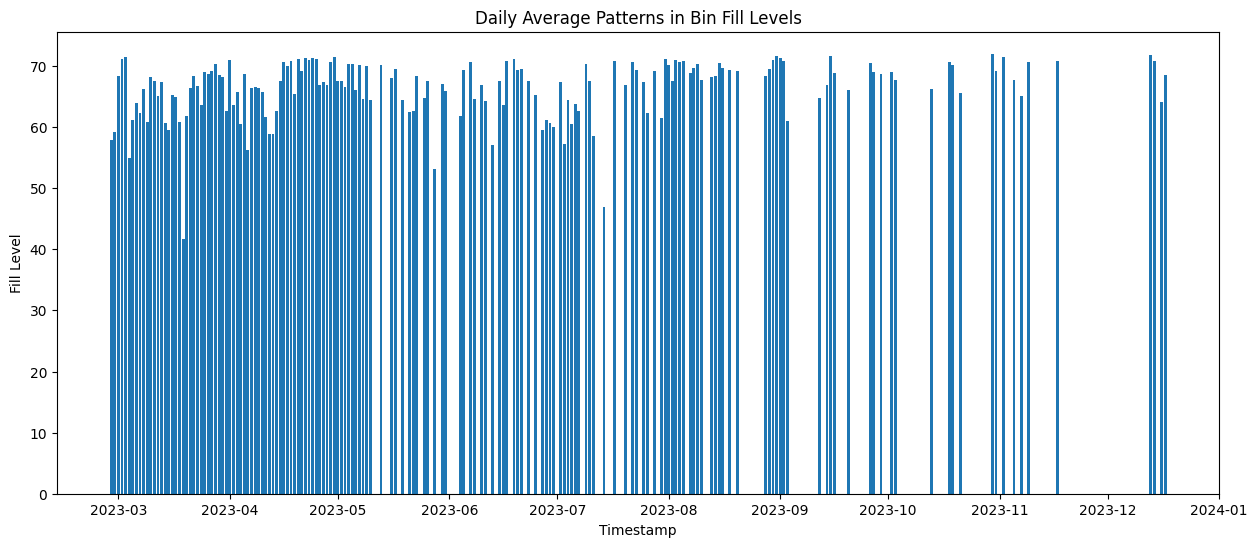

In [279]:
# Plot temporal patterns in daily average bin fill levels
plt.rcParams['figure.figsize'] = [15, 6]
plt.bar(grouped_bin_sensor_daily['date_time'], grouped_bin_sensor_daily['fill_level'])
plt.title('Daily Average Patterns in Bin Fill Levels')
plt.xlabel('Timestamp')
plt.ylabel('Fill Level')
plt.show()



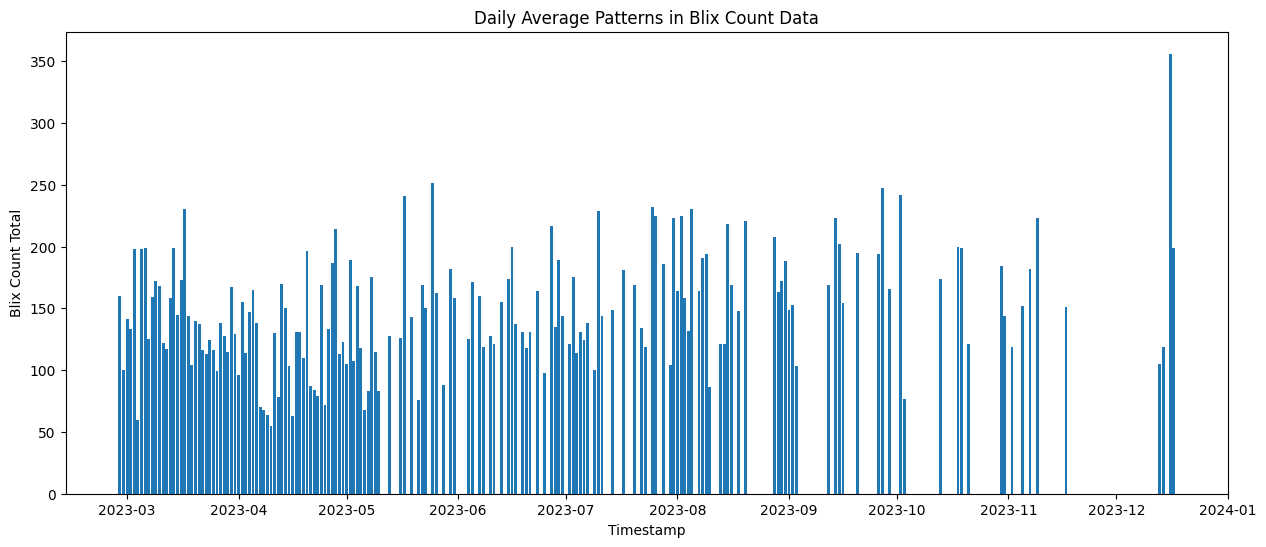

In [280]:
# Plot temporal patterns in daily average blix count
plt.bar(grouped_bin_sensor_daily['date_time'], grouped_bin_sensor_daily['total'])
plt.title('Daily Average Patterns in Blix Count Data')
plt.xlabel('Timestamp')
plt.ylabel('Blix Count Total')
plt.show()

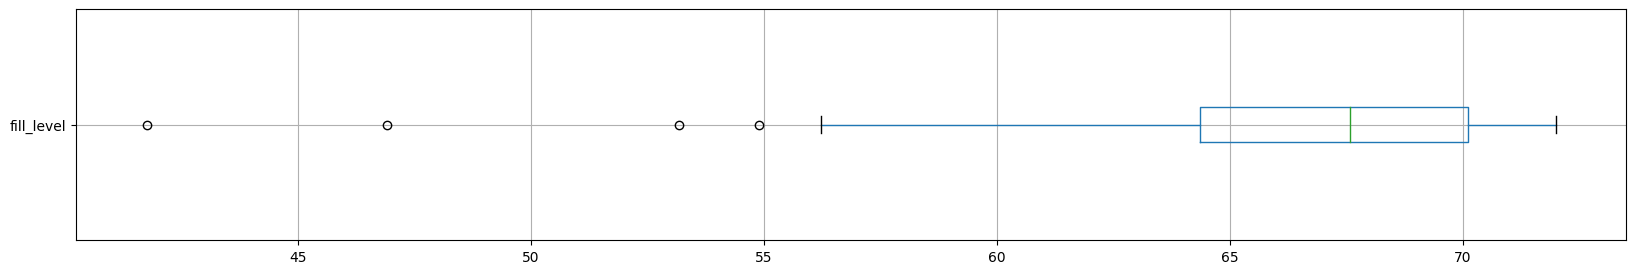

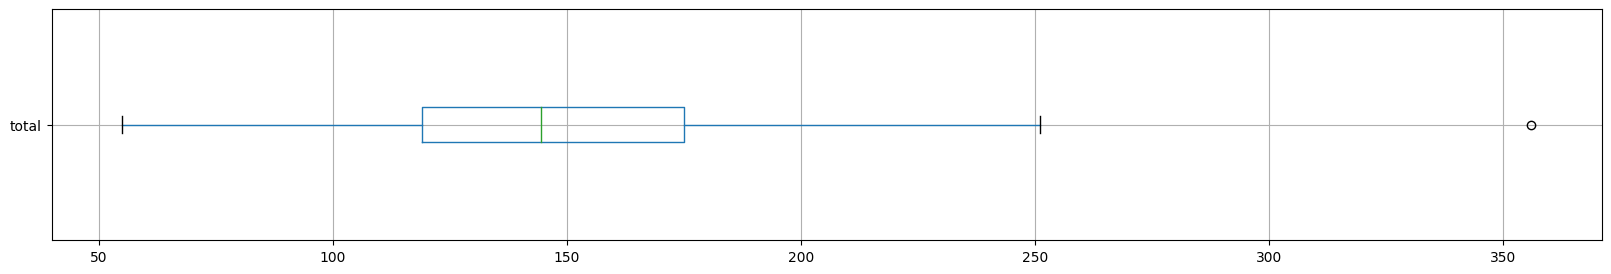

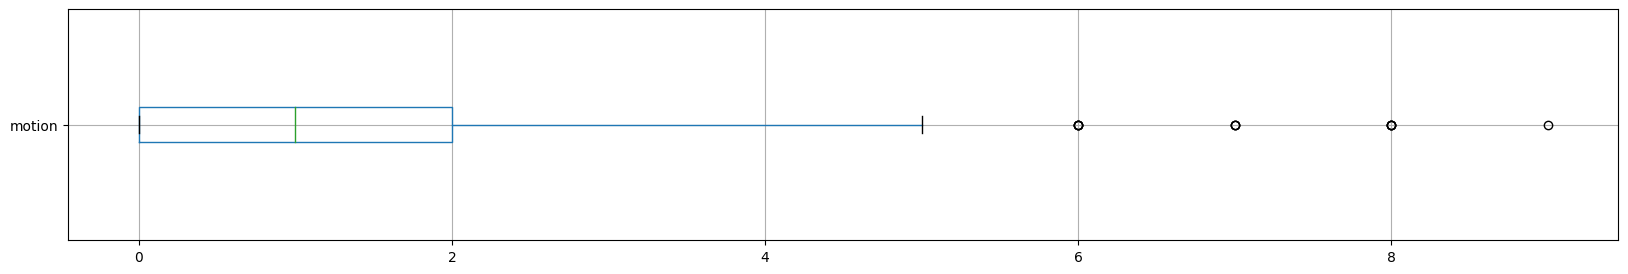

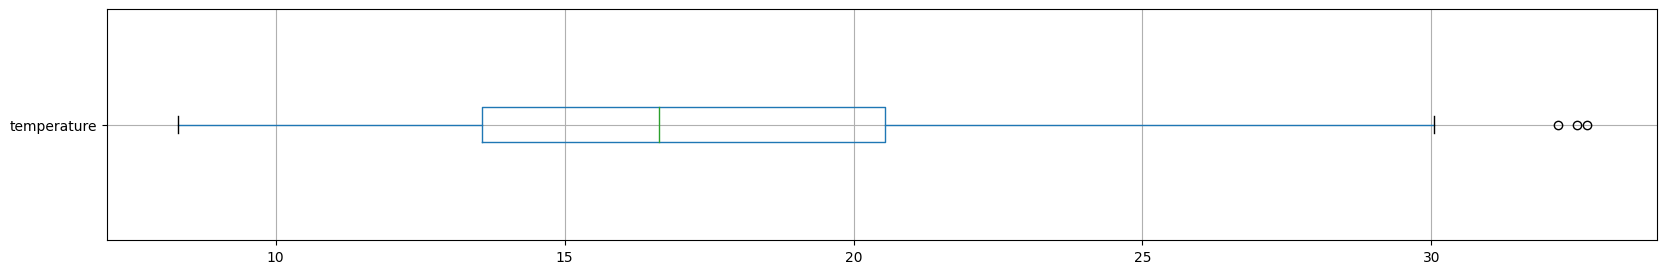

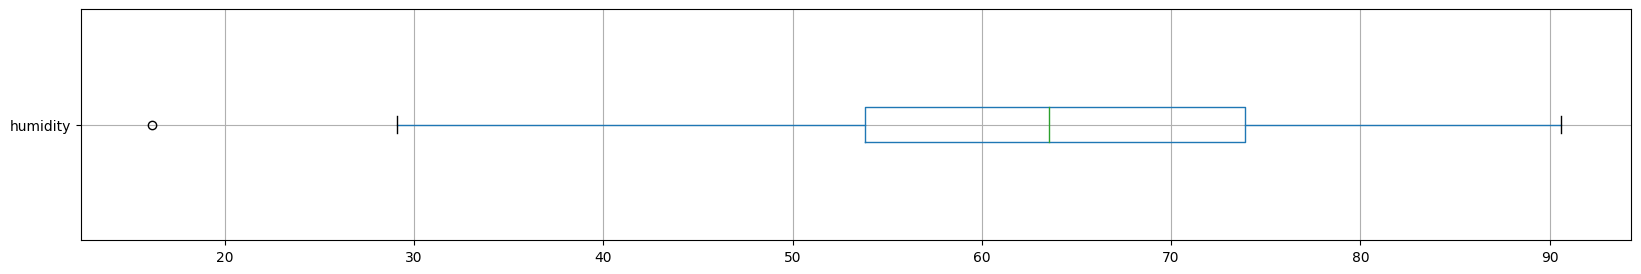

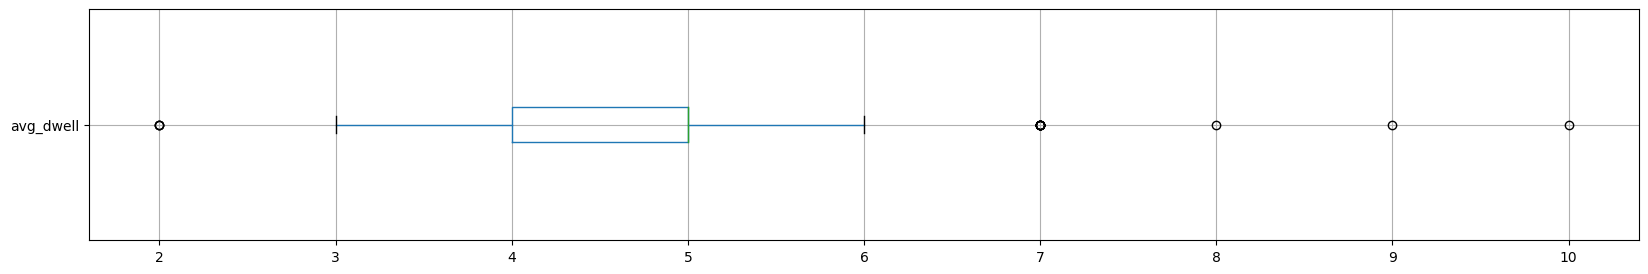

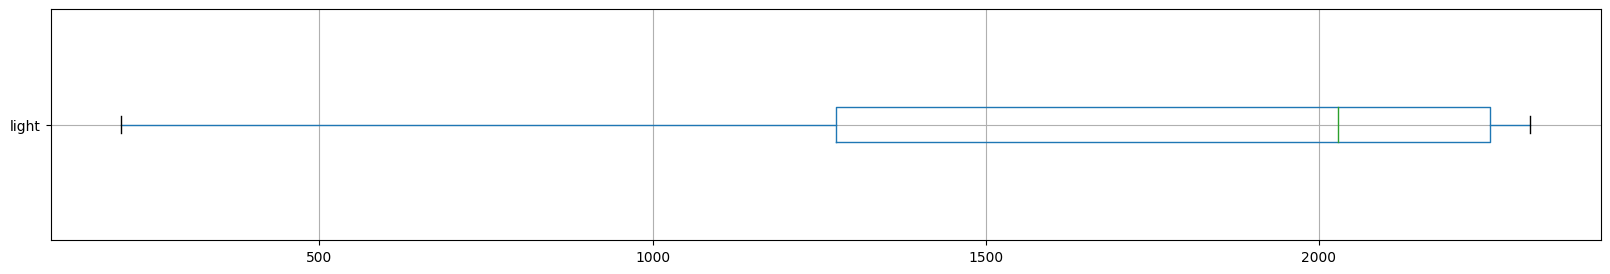

In [281]:
# Use box plots to check for any unexpected values in data
# Set index to datetime column
daily_merged_date_index = grouped_bin_sensor_daily.set_index('date_time')
# Iterate over columns and create a horizontal box plot for each one
for column in daily_merged_date_index:
    plt.rcParams["figure.figsize"] = (20,3)
    plt.figure()
    daily_merged_date_index.boxplot([column], vert=False)
plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [282]:
# Drop rows total over 500
daily_merged_date_index = daily_merged_date_index[daily_merged_date_index['total'] < 500] 


### FEATURE CORRELATION

#### Hourly Data

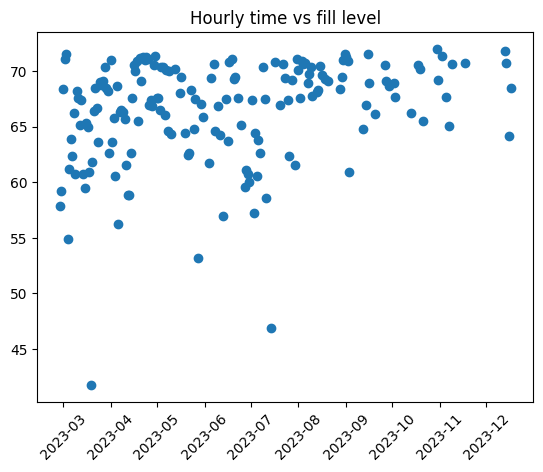

In [288]:
# Create scatter plots of datetime vs all other variables
# Add index column
hourly_merged_number_index = hourly_merged_date_index.reset_index()

# Create a plot of time vs filllevel
plt.scatter(hourly_merged_number_index['date_time'], hourly_merged_number_index['fill_level'])
plt.title("Hourly time vs fill level")
plt.xticks(rotation=45)
ax = plt.gca()

plt.show()

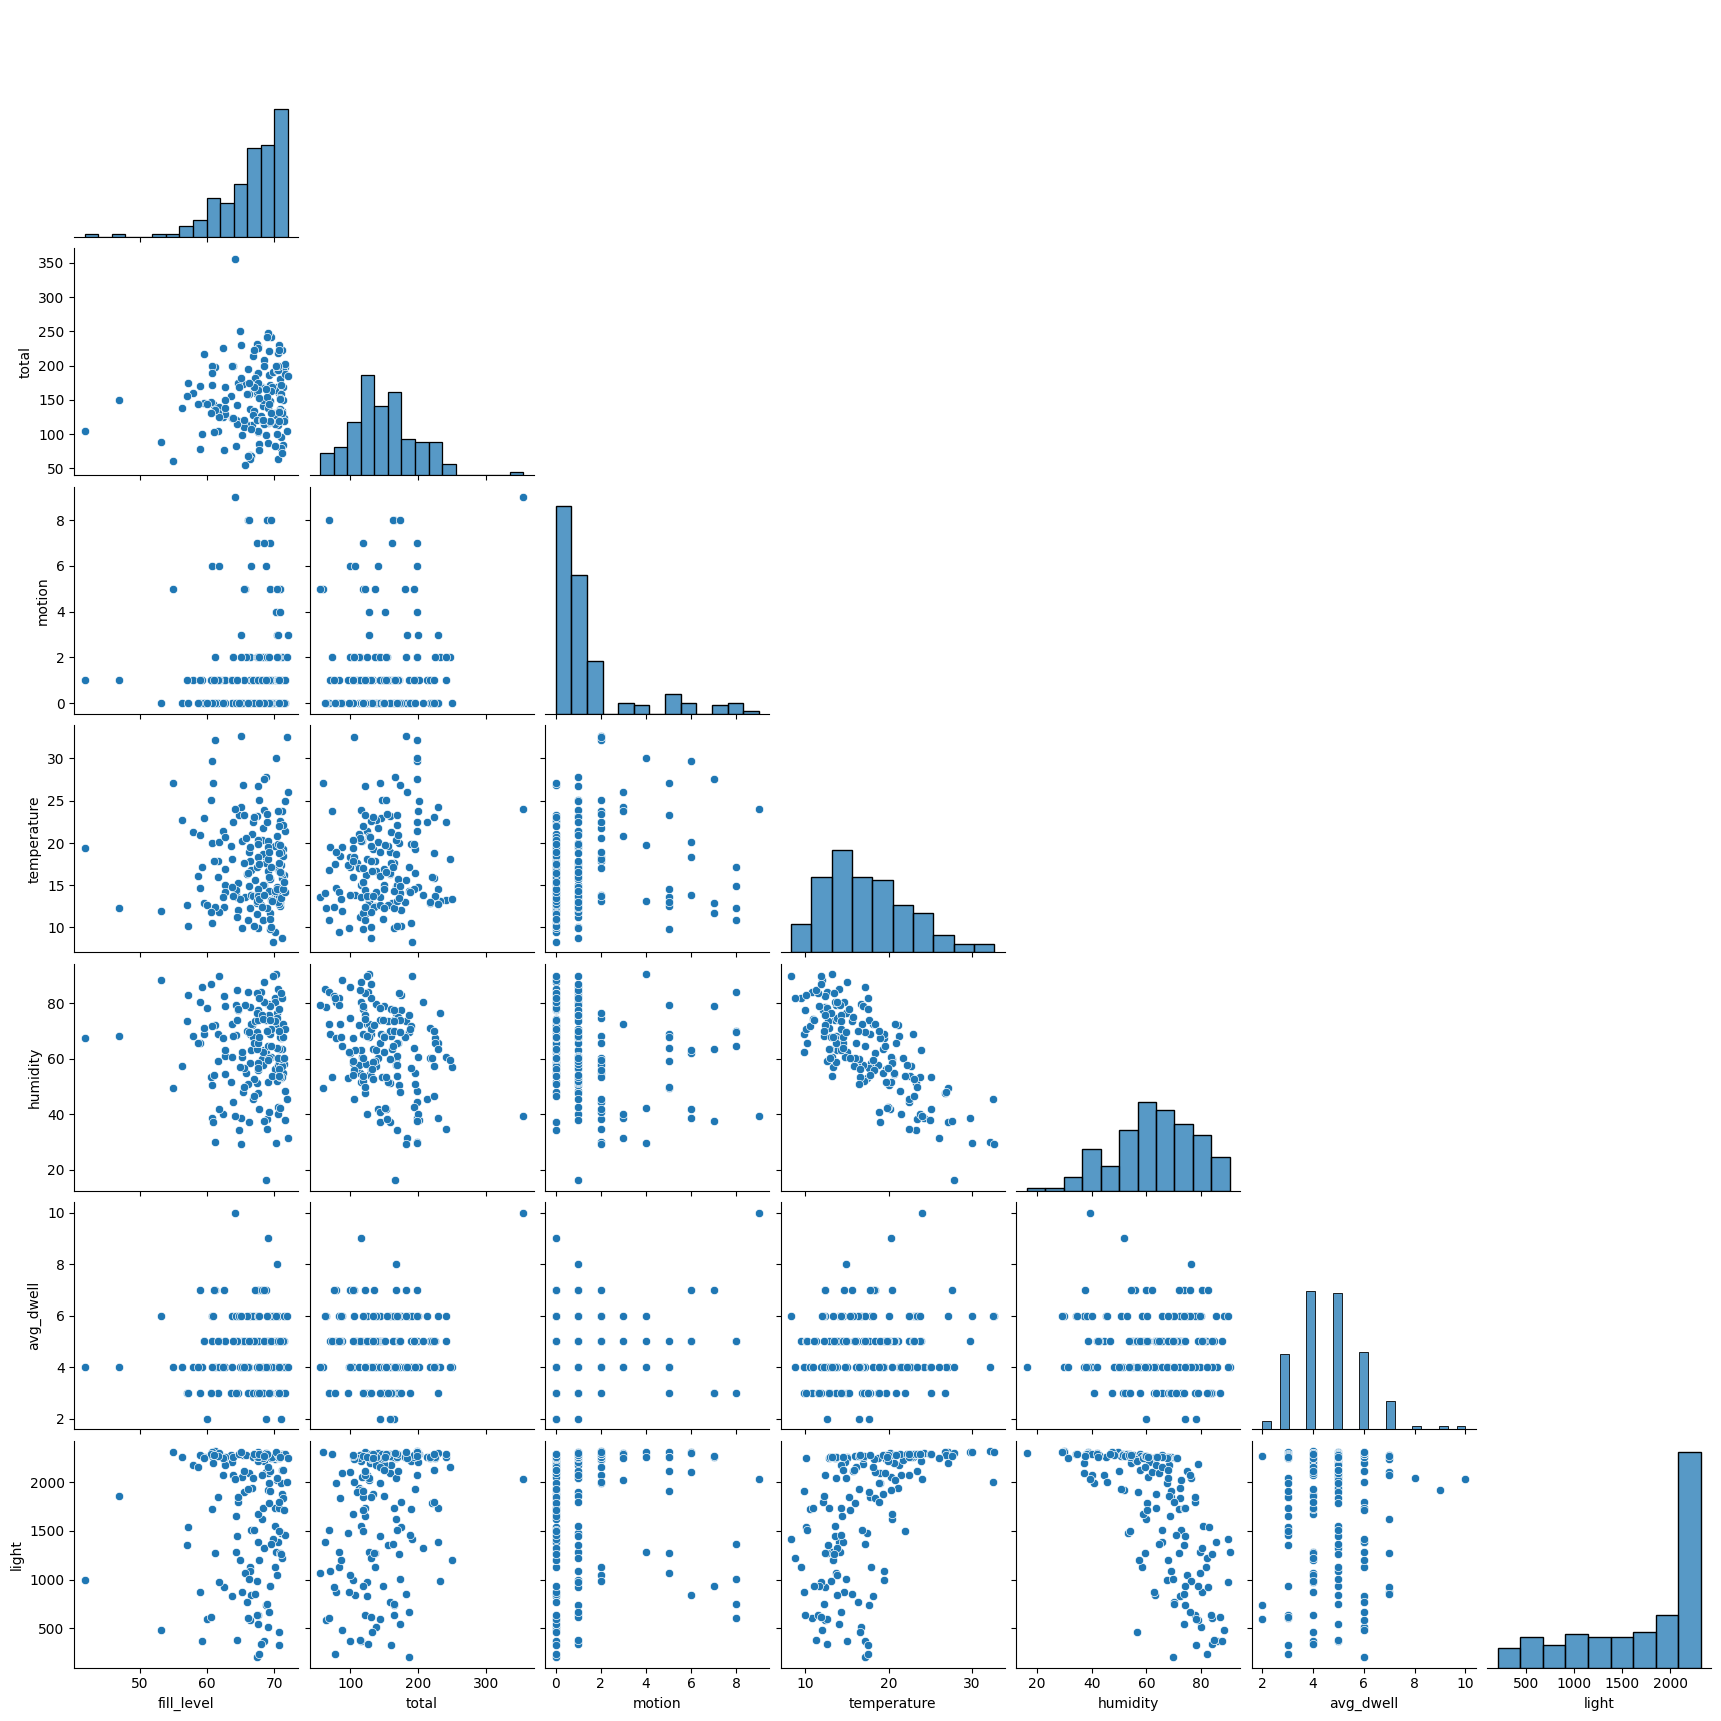

In [284]:
sns.pairplot(hourly_merged_date_index, corner=True)
plt.show()

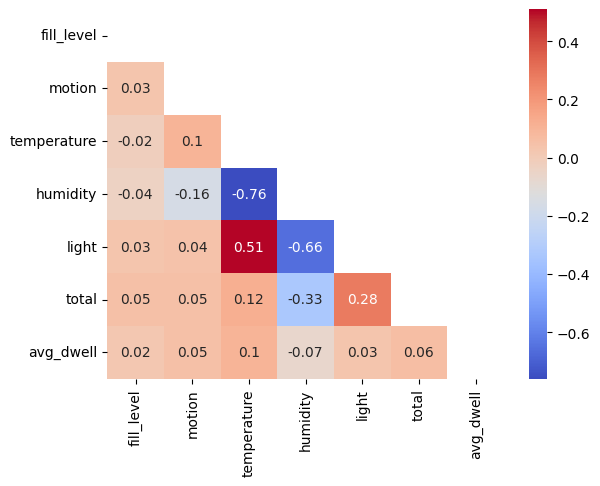

In [220]:
# Calculate correlation heatmap for all columns
matrix = hourly_merged_date_index.corr(method = 'pearson').round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
color = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(matrix, annot=True, cmap=color, mask=mask)

plt.show()

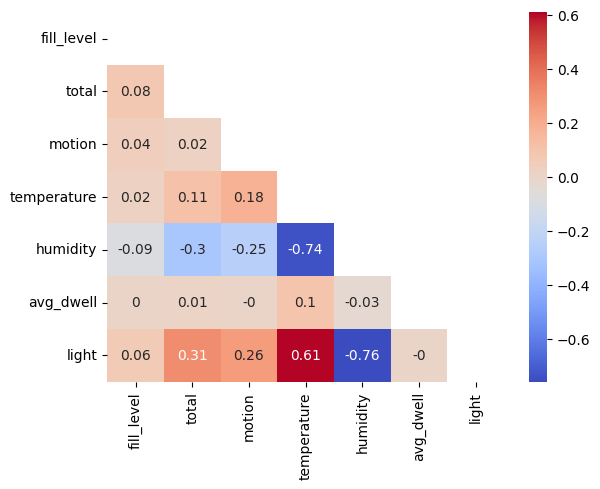

In [289]:
# Calculate correlation heatmap for all columns
matrix = hourly_merged_date_index.corr(method = 'spearman').round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
color = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(matrix, annot=True, cmap=color, mask=mask)

plt.show()

All data is in one table. Data now needs to be investigated to check the range of values in each column. This will be done using a series of box and whiskar plots. Bos and whiskar plot are choosen as they give the range, median and show the distribution of the data, as well as visualising the presence of outiers.

The box plots show the disributions of the data in each column. All distributions are within expected ranges for the data types so no action will be taken on outliers.

#### Daily Data

A scatterplot is used to identify if there is a relationshsips between bin fill level and time.

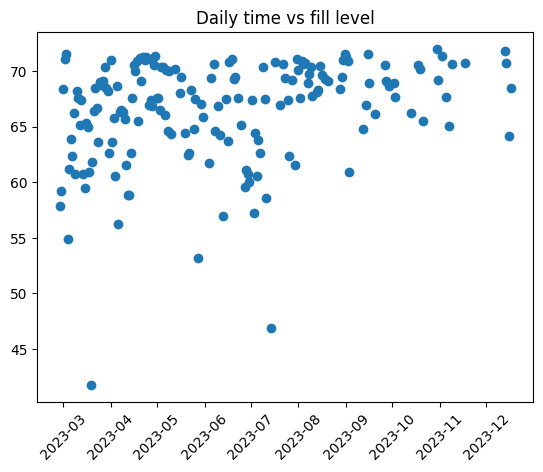

In [287]:
# Create scatter plots of datetime vs all other variables
# Add index column
daily_merged_number_index = daily_merged_date_index.reset_index()

# Create a plot of time vs filllevel
plt.scatter(daily_merged_number_index['date_time'], daily_merged_number_index['fill_level'])
plt.title("Daily time vs fill level")
plt.xticks(rotation=45)
ax = plt.gca()

plt.show()


From the scatterplots against time, bin fill levels remained below 75% in 2023 between March and August. From September 2023 to mid March, bin fill levels have much more variation. For this reason, data prio to 2023 will be deleted from the dataset.

A Pairs plot will be used to visualise the relationships between numeric variables. To better understand these relationships, Z-score standardisation will be carried out on all columns. As some data columns have very large values and others very small, these is a need to standardise the data. Z-score scaling is used as some data columns have small outliers (which make sense within their datasets). This ensures all features have a mean of 0 and a standard deviation of 1. This also means that when used in modelling the values of one feature will not skew the model results. 

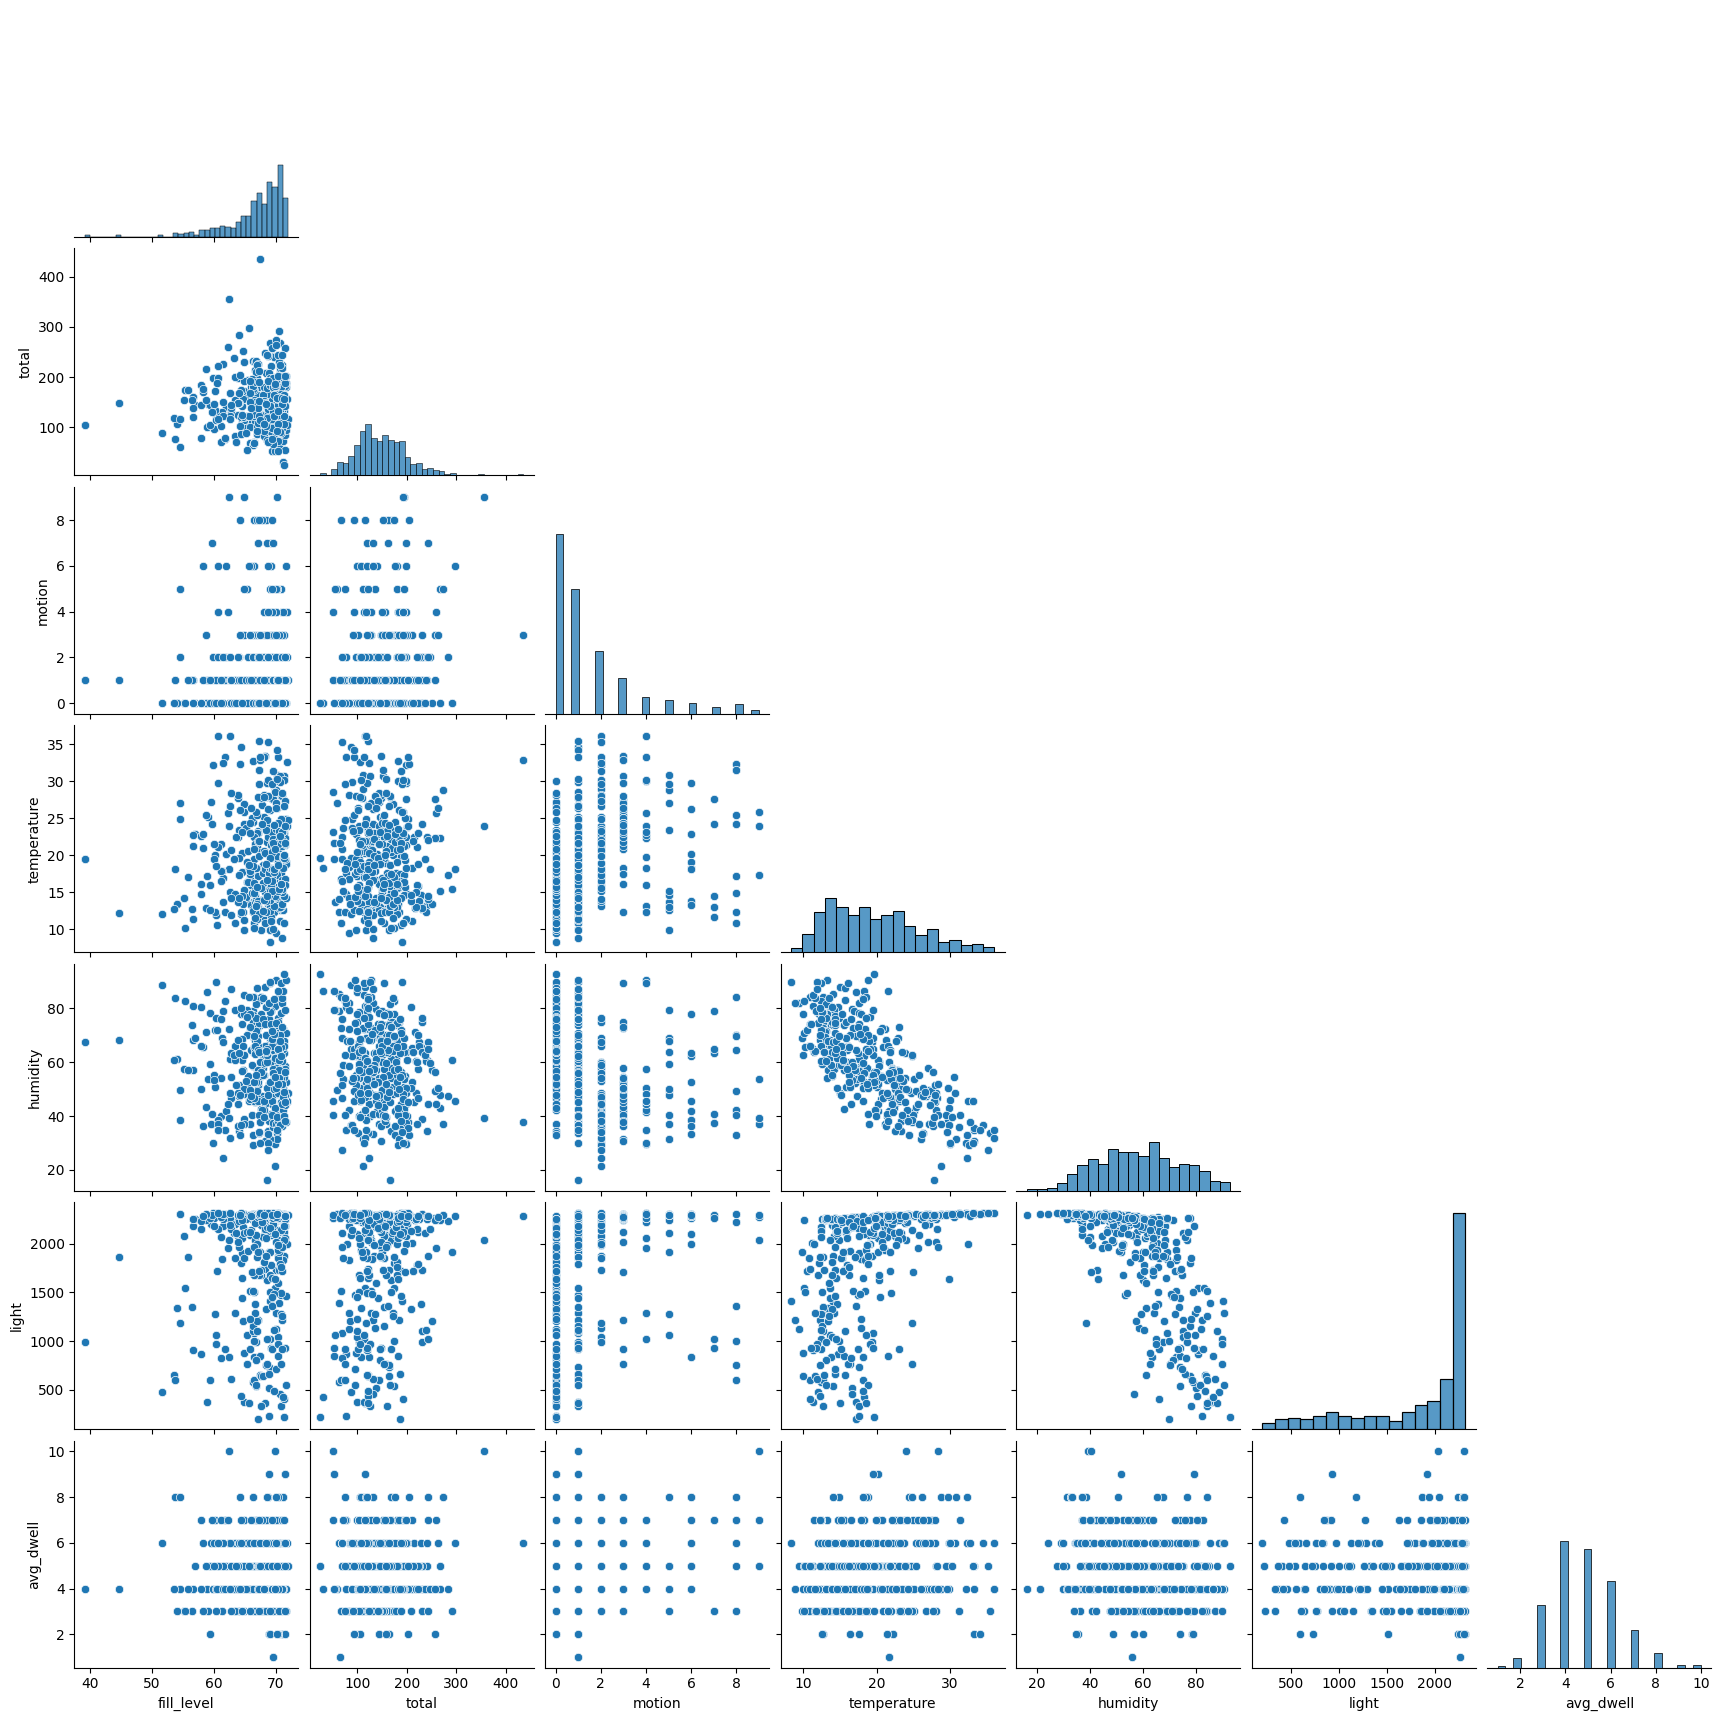

In [ ]:
# Create a pairsplot to look at relationships between numerical variables
sns.pairplot(daily_merged_date_index, corner=True)
plt.show()

The pairs plot shows a relationship between numerical variables. Temperature and humidity have the strongest linear reationship, followed by light with temperature and light with humidity. The goal of this task is to find relationships between sensor data and bin fill levels. High total numbers of people also appear to have a relationship with bin fill level; every high value for attendeers except for one correlated to a high bin fill level.

Int the correlation heatmap, Pearson correlation is used to determine extent of linear relationship between each pair of variables. This is because several of the variables are seen to have a strong linear relationship and this needs to be measured.

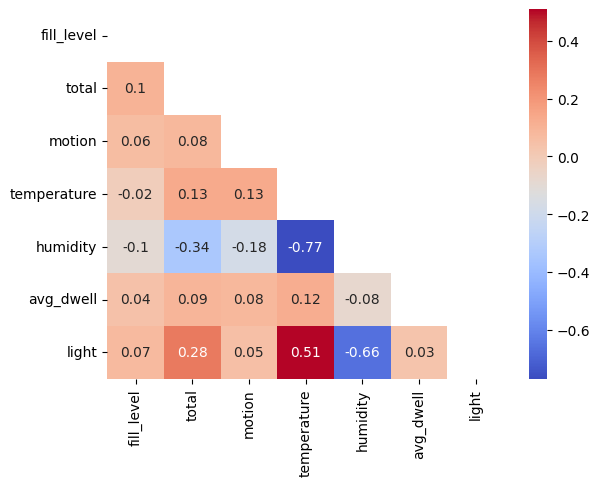

In [290]:
# Calculate correlation heatmap for all columns
matrix = daily_merged_date_index.corr(method = 'pearson').round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
color = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(matrix, annot=True, cmap=color, mask=mask)

plt.show()

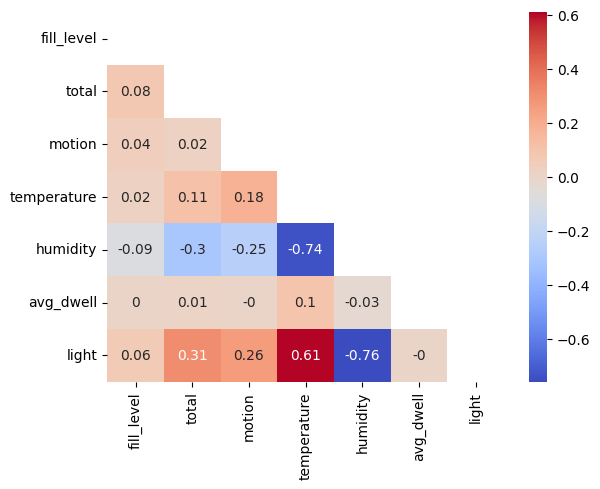

In [291]:
# Calculate correlation heatmap for all columns
matrix = daily_merged_date_index.corr(method = 'spearman').round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))
color = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(matrix, annot=True, cmap=color, mask=mask)

plt.show()

The correlation heatmap shows the extent of the linear relationship between variables. The strongest linear relaionship is shown to be between total and dwell data. Humidity and temperature also have a strong linear correlation, followed by light and temperature. In this investigation the focus is on the relationship between fill level and other variables. The highest linear relationship including bin fill level is between fill level and time, at 0.8 positive linear relationship. Next is temperature and bin fill level, with has a medium negative linear correlation of 0.34, followed by other weather related variables. Motion, dwelling and total are seen to have weak negative linear relationships with bin fill level. Of note, bin fill level and total are seen to have a very weak negative relationship.

As few variables exhibit a strong linear relationship with bin fill level in the heatmap or pairplot, the existance of non-linear relationships should also be measured. The Distance Correlation uses the dcor package to help capture the extent of non-linear correlation between variables and bin fill level. As bin fill level is the main variable of interest, measurements of each varaibles correlation to fill level will be calculated. It is important to note that date time is not supported in the distance calculation function.

In [ ]:
# Calculate distance correlation between numerical variables and bin fill level (Datetime not supported)
print("filllevel and total =" , dcor.distance_correlation(summer_event_standard['filllevel'],summer_event_standard['total']))
print("filllevel and avg_dwell =" , dcor.distance_correlation(summer_event_standard['filllevel'],summer_event_standard['avg_dwell']))
print("filllevel and motion =" , dcor.distance_correlation(summer_event_standard['filllevel'],summer_event_standard['motion']))
print("filllevel and temperature =" , dcor.distance_correlation(summer_event_standard['filllevel'],summer_event_standard['temperature']))
print("filllevel and humidity =" , dcor.distance_correlation(summer_event_standard['filllevel'],summer_event_standard['humidity']))
print("fillevel and light =" , dcor.distance_correlation(summer_event_standard['filllevel'],summer_event_standard['light']))


filllevel and total = 0.11329265199868836
filllevel and avg_dwell = 0.10457769882933886
filllevel and motion = 0.11242902529074322
filllevel and temperature = 0.32752361830690785
filllevel and humidity = 0.26241949123613756
fillevel and light = 0.14749167719499412


The strongest non-linear correlations measured remain between bin fill level and weather variables of temperature, humidity and light. The total, average dwelling and motion all have around 10% correltaion with bin fill level. This means there is likely a non-linear correlation bwteen these variables and the bin fill level.

### FEATURE ENGINEERING

An important role of exploratory data analysis is identifying feature correlation. The results of this correlation is used in the selection of features on which to carry out modelling processes. Correlated features need to be removed prior to predictive modelling taking place. This can be done in several ways, including PCA and domain knowledge. 

PCA feature selection uses a mathematic transformation to project the variables to a new co-ordinate system <a href="#fn-4">[4]</a>. This apporach selects the most important attributes that best explain the variance of the dependent variable, removng correlation between features. However, the components no longer represent individual data (temperature, total, motion) etc, insetad become a combination which is not clearly identfiable. This means that it would be much harder to explain how the modelling works and to make future predictions. For this reason, the use of PCA is not appropriate for this use case.

Domain knowledge is determined as the best method for feature selection in this use case. This allows doamin knowleedeg fo relationships to be used to reduce fatures used in modelling to make mor uable prediction models.

The features choosen to be removed are light and humidity, due to their strong linear relationships with temperature. Time data will also be removed from the modelling data, as time period is specified as over summer not per date.

In [ ]:
# Set date_time as index as cannot apply z-score function to it
summer_event.set_index('date_time', inplace=True)
# Apply z-score standardisation to all columns
summer_event_standard = summer_event.apply(zscore)
summer_event_standard.head(3)

In [ ]:
# Select required features for modelling
model_dataframe = summer_event_standard[['filllevel','motion','temperature','total']]
# Drop datetime index and replace with number index
model_dataframe = model_dataframe.reset_index(drop=True)
print(len(model_dataframe))
model_dataframe.head(3)

410


,filllevel,motion,temperature,total
0,0.369115,-0.860234,-0.642473,0.187649
1,0.369115,-1.241527,-0.860111,-0.362103
2,0.369115,-0.860234,-1.246927,-0.342643


### PREDICTIVE MODELLING

The main issue in predictive modelling for this use case is the small dataset size. To solve the problem of little data, research was completed to try to find open datasets conatining smart bin fill level data, stage use data, pedestrian counts and temperature but no datasets of corresponding locations open source could be found. The Australian Government data portal <a href="#fn-5">[5]</a> currenlty holds data on smart bins for Wyndham and Mildura areas. Pedestrian data is availible for Liverpoool, Ballarat, City of Casey, City of Sydney and Greater Geelong. Stage use data could not be found at any locations. As it is evident that there is no overlap between these datasets, additional data cannot be found within Australia. Kaggle <a href="#fn-6">[6]</a> was also searched, again reporting no appropriate international datasets. As it is assumed over time that the datasets used in this use case will increase as sensors as still in place, predictive modelling will become more accurate as data sets increase.

A regression algorithm will be used to predict bin fill levels from the prepared dataset. Regression is choosen as it makes predictions on continuos variables with known measurements of the dependent variable, as in the case of bin fill levels. Support Vector Regression (SVR) finds the best fit to predeict target variables without overfitting data. In addition, it allows kernals of different shape to be used <a href="#fn-7">[7]</a>. As there is no obvious relationship between the target bin data variable and the predictor variables; linear, polynomial and radial basis function kernals can all be compared to find which gives the best model for prediction.

Model performance will be evaluated using accuracy, coefficient of determination (r-squared value) and root mean squared error (rmse). The accuracy of the model is calculated by dividing the total number of times the prediction exactly matches the data value in the table and dividing by the total number of predictions. The r-squared value indicates how much variation in the target variabe is eplained by the dataset, while the rmse is a measure of the how far the prediction estmates are from the actual data values <a href="#fn-8">[8]</a>.

#### PREDICTIVE MODELLING Preprocessing

First, a function will be created to calculate accuracy. Data will then be split into a test-train split, with 30% of data held as the test set and 70% of data used to train the model.

In [ ]:
# Make function to analyse accuracy of predictions
def compute_accuracy(y_true, y_pred):
    correct_predictions = 0
    # iterate over each label and check
    for true, predicted in zip(y_true, y_pred):
        if true == predicted:
            correct_predictions += 1
    # compute the accuracy
    accuracy = round(correct_predictions/len(y_true)*100,2)
    print(f"accuracy: {accuracy}%")

In [ ]:
# Set the x and y variables. Drop date_time as it is not supported by linear or random forest
X = model_dataframe_standard.drop(["filllevel"], axis=1)
y = model_dataframe_standard["filllevel"]

# Set up the test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Create function for hyperparameter tuning with random search
def hyperparameter_tune(svr, parameters, iterations, X, y):
    randomSearch = RandomizedSearchCV(
        svr,
        param_distributions=parameters,
        n_jobs=-1,
        n_iter=iterations,
        cv=2
    )
    # Fit the model and find the best hyperparameters
    randomSearch.fit(X_train,y_train)
    return randomSearch.best_params_

PREDICTIVE MODEL - Linear Regression

Linear regression assumes an underlying linear relationship between the features of interest and bin fill level. A randomised search will be carried out to tune the parameters for the SVR model with linear kernel. The best parameters will then be passed into the model and the model performance evaluated.

In [ ]:
# Hyperparameter tuning
# Initiate instance of SVR
svr  = SVR ()

# Set parameters for random search to test
parameters = {
    'C':[0.01,0.1,1,10],
    'kernel' : ["linear"],
    'degree' : [1,3,5,7],
    'gamma' : [0.01,1]
}

# Call random search function on linear SVR
best_params = hyperparameter_tune(svr, parameters, iterations=10, X=X_train, y=y_train)
# Print results of random search
print("Best hyperparameters for linear:", best_params)

Best hyperparameters for linear: {'kernel': 'linear', 'gamma': 0.01, 'degree': 3, 'C': 0.01}


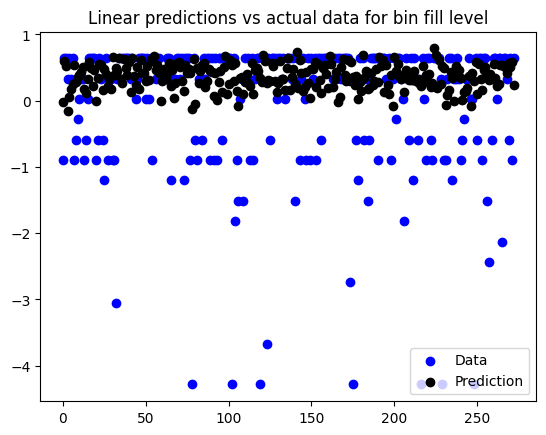

accuracy: 0.0%
r2: -0.07
rmse: 1.06


In [ ]:
# Modelling
# Initiate SVR model with best parameters
model = SVR(kernel="linear",C=0.01,degree=7,gamma=1)
# Fit the model with the training data
model.fit(X_train, y_train)
# Make predictions with the data
predictions = model.predict(X_test)

# Graph predictions against test data values
plt.scatter(range(len(y_test)), y_test, color='blue', label='Data')
plt.scatter(range(len(predictions)), predictions, color='black',label='Prediction')
plt.title("Linear predictions vs actual data for bin fill level")
plt.legend(loc='lower right')
plt.show()

# Calculate the accuracy of the model
compute_accuracy(y_test, predictions)

# Calculate the r2 score
r2_score = round(metrics.r2_score(y_test, predictions),2)
print(f'r2: {r2_score}')

# Calculate the rmse
rmse = round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2)
print(f'rmse: {rmse}')

The linear regression model aims to predict the standardised values in the bin fill level column from the linear relationship from the standardsed variables of temperature, total and motion. The scatterplot compares the model predictions to actual values. From this plot it is seen that the SVR with linear regression kernal has a tendency to return below average bin fill levels, with most predictions below the mean of 0. Of note there are many values redicted above 1.5 standard deviations above the mean but none below 1.5 standard deviations from the mean.</br>

Model performance is evaluated using accuracy, r-squared and rmse calculations. The SVR with linear kernal model made 0 accurate predictions. The r-squared value is also very low, at 0.06, meaning that the model explains very little of the variation in the bin fill level variable around its mean. The rmse value at 97% is high, indicating that prediction estimates are all far from actual data values.These model performance measurements show the model is working poorly to predict bin fill levels from data given.


PREDICTIVE MODEL - Polynomial Regression

Polynomial regression assumes a non-linear relationship between the features of interest and bin fill level. As with the linear model, a randomised search will be carried out to tune the parameters for the SVR model with polynomial kernel. The best parameters will then be passed into the model and the model performance evaluated.

In [ ]:
# Hyperparameter tuning
# Set parameters for random search to test
parameters = {
    'C':[0.01,0.1,1,10],
    'kernel' : ["poly"],
    'degree' : [1,3,5,7],
    'gamma' : [0.01,1]
}

# Call random search function on polynomial SVR
best_params = hyperparameter_tune(svr, parameters, iterations=10, X=X_train, y=y_train)
# Print results of random search
print("Best hyperparameters for polynomial:", best_params)

KeyboardInterrupt: 

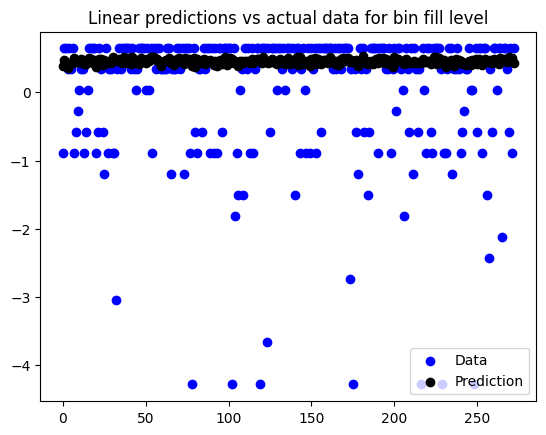

accuracy: 0.0%
r2: -0.18
rmse: 1.11


In [ ]:
# Modelling
# Initiate SVR model with best parameters
model = SVR(kernel="poly",C=0.01,degree=1,gamma=0.01)
# Fit the model with the training data
model.fit(X_train, y_train)
# Make predictions with the data
predictions = model.predict(X_test)

# Graph predictions against test data values
plt.scatter(range(len(y_test)), y_test, color='blue', label='Data')
plt.scatter(range(len(predictions)), predictions, color='black',label='Prediction')
plt.title("Linear predictions vs actual data for bin fill level")
plt.legend(loc='lower right')
plt.show()

# Calculate the accuracy of the model
compute_accuracy(y_test, predictions)

# Calculate the r2 score
r2_score = round(metrics.r2_score(y_test, predictions),2)
print(f'r2: {r2_score}')

# Calculate the rmse
rmse = round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2)
print(f'rmse: {rmse}')

PREDICTIVE MODEL - Radial Basis Function Regression

Radial basis function regression assumes a gaussian relationship between the features of interest and bin fill level. As with the models above, randomised search will be carried out to tune the parameters for the SVR model with an rbf kernel. The best parameters will then be passed into the model and the model performance evaluated.

In [ ]:
# Hyperparameter tuning
# Set parameters for random search to test
parameters = {
    'C':[0.01,0.1,1,10],
    'kernel' : ["rbf"],
    'degree' : [1,3,5,7],
    'gamma' : [0.01,1]
}

# Call random search function on rbf SVR
best_params = hyperparameter_tune(svr, parameters, iterations=10, X=X_train, y=y_train)
# Print results of random search
print("Best hyperparameters for rbf:", best_params)

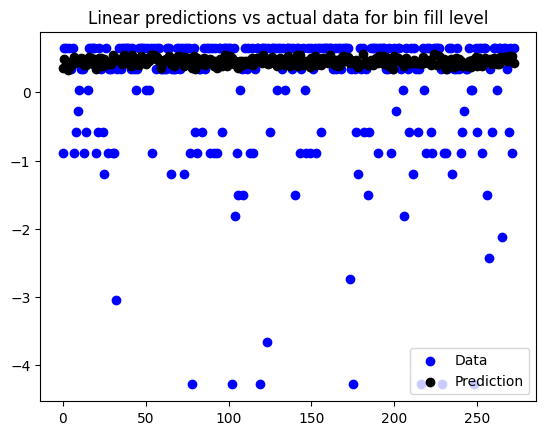

accuracy: 0.0%
r2: -0.17
rmse: 1.11


In [ ]:
# Modelling
# Initiate SVR model with best parameters
model = SVR(kernel="rbf",C=0.01,degree=1,gamma=0.01)
# Fit the model with the training data
model.fit(X_train, y_train)
# Make predictions with the data
predictions = model.predict(X_test)

# Graph predictions against test data values
plt.scatter(range(len(y_test)), y_test, color='blue', label='Data')
plt.scatter(range(len(predictions)), predictions, color='black',label='Prediction')
plt.title("Linear predictions vs actual data for bin fill level")
plt.legend(loc='lower right')
plt.show()

# Calculate the accuracy of the model
compute_accuracy(y_test, predictions)

# Calculate the r2 score
r2_score = round(metrics.r2_score(y_test, predictions),2)
print(f'r2: {r2_score}')

# Calculate the rmse
rmse = round(np.sqrt(metrics.mean_squared_error(y_test, predictions)),2)
print(f'rmse: {rmse}')

### FINDINGS

The findings of this investigation into the variables effecting bin fill level at Argyle Square are inconclusive. It was expected that the total number of people would impact the bin fill level. However, Pearson correlation found a very weak negaive association, while the distance calcution also found a very weak correlation. 


 This suggests that the data set is not yet large enough to be used in predictive anaylsis. This is supported by the size of the dataset; because the data set is so small and contains data from only one year (after all data cleaning and merging has taken place) there is not enough data to build an accurate predictive model from. Over time, as the data sets used in this use case grow, this use case could be used as a basis for creating a predicitive model.

##### References

<fn id="fn-1">[1]</fn> Ecube Labs (2016) [Overflowing garbage bins: 5 impacts on health and environment, and how to prevent.](https://www.ecubelabs.com/overflowing-garbage-bins-5-impacts-on-health-and-environment-and-how-to-prevent/). Ecube Labs, North America & Asia. 

<fn id="fn-2">[2]</fn> Ferrer, J & Alba, E (2019) [BIN-CT: Urban waste collection based on predicting the container fill level](https://www.sciencedirect.com/science/article/abs/pii/S0303264718301333). BioSystems, Vol 186. England. 

<fn id="fn-3">[3]</fn> Participate Melbourne (2022) [Data in the Park - Argyle Square.](https://participate.melbourne.vic.gov.au/emerging-tech-testbed/data-park). City of Melbourne Council, Australia.

<fn id="fn-4">[4]</fn> Geeks for Geeks (2023) [What is Feature Engineering?](https://www.geeksforgeeks.org/what-is-feature-engineering/). Geeks for Geeks.

<fn id="fn-5">[5]</fn> Australian Government Data (2024) [data.gov.au](https://data.gov.au/). Australian Governemnt.

<fn id="fn-6">[6]</fn> Kaggle (2024) [Kaggle](https://www.kaggle.com/). Kaggle.

<fn id="fn-7">[7]</fn> Clarity Knowledge Base (2023) [From Theory to Practice: Implementing Support Vector Regression for Predictions in Python](https://medium.com/@niousha.rf/support-vector-regressor-theory-and-coding-exercise-in-python-ca6a7dfda927). Towards Data Science.

<fn id="fn-8">[8]</fn> Niousha Rasifaghihi (2023) [What are R² and RMSE?](https://click.clarity.io/knowledge/r2-rmse). Clarity io, United States of America.